## Library import

In [2]:
import pandas as pd
import os
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from torch import optim
import torch.nn.functional as F
from tqdm import tqdm
from transformers import BertForSequenceClassification, BertConfig, BertTokenizer

In [3]:
userPATH ='revision_dataset/'
tweetPATH = 'revision_dataset/tweetAgg/'

In [4]:
userlvltrain = pd.read_csv(userPATH+'/userlvltrain.csv')
userlvltest = pd.read_csv(userPATH+'/userlvltest.csv')
userlvlval = pd.read_csv(userPATH+'/userlvlval.csv')

In [5]:
train_df = pd.read_csv(tweetPATH+'aggtrain_df.csv')
train_df['userLocation'] = userlvltrain.userLocation
test_df = pd.read_csv(tweetPATH+'aggtest_df.csv')
test_df['userLocation'] = userlvltest.userLocation
val_df = pd.read_csv(tweetPATH+'aggval_df.csv')
val_df['userLocation'] = userlvlval.userLocation

In [6]:
# prepare data for BERT training and save in newdata/
if not os.path.exists('newdata/'): 
    os.mkdir('newdata/')
    train_df.to_csv('newdata/train.csv', index=False)
    test_df.to_csv('newdata/test.csv', index=False)
    val_df.to_csv('newdata/dev.csv', index=False)

possible_labels = train_df.userLocation.unique()
possible_labels.sort()
label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index
print(label_dict)
inv_label_dict = {v: k for k, v in label_dict.items()}
print(inv_label_dict)

{'bali dan nusa tenggara': 0, 'jabodetabek': 1, 'jawa barat dan banten': 2, 'jawa tengah dan yogyakarta': 3, 'jawa timur': 4, 'kalimantan': 5, 'maluku dan papua': 6, 'sulawesi': 7, 'sumatera': 8}
{0: 'bali dan nusa tenggara', 1: 'jabodetabek', 2: 'jawa barat dan banten', 3: 'jawa tengah dan yogyakarta', 4: 'jawa timur', 5: 'kalimantan', 6: 'maluku dan papua', 7: 'sulawesi', 8: 'sumatera'}


## Setting Cuda

In [7]:
!nvidia-smi

Sun Mar 13 11:56:14 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.126.02   Driver Version: 418.126.02   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:06:00.0 Off |                    0 |
| N/A   34C    P0    57W / 300W |  20179MiB / 32480MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  On   | 00000000:07:00.0 Off |                    0 |
| N/A   44C    P0   155W / 300W |  17467MiB / 32480MiB |     90%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [8]:
torch.cuda.set_device(3)
device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')
device_idx = "cuda:3"
torch.cuda.current_device()

3

In [9]:
import random 
import numpy as np

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    
def count_param(module, trainable=False):
    if trainable:
        return sum(p.numel() for p in module.parameters() if p.requires_grad)
    else:
        return sum(p.numel() for p in module.parameters())
    
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def metrics_to_string(metric_dict):
    string_list = []
    for key, value in metric_dict.items():
        string_list.append('{}:{:.2f}'.format(key, value))
    return ' '.join(string_list)

def location_prediction_metrics(list_hyp, list_label):
    metrics = {}
    metrics["ACC"] = accuracy_score(list_label, list_hyp)
    metrics["F1"] = f1_score(list_label, list_hyp, average='macro')
    metrics["REC"] = recall_score(list_label, list_hyp, average='macro')
    metrics["PRE"] = precision_score(list_label, list_hyp, average='macro')
    return metrics


class LocationPredictionDataset(Dataset):
    # Static constant variable
    LABEL2INDEX = label_dict
    INDEX2LABEL = inv_label_dict
    NUM_LABELS = 9
    
    def load_dataset(self, path): 
        df = pd.read_csv(path, sep=',')
        # df.columns = ['screenName','tweets','userLocation', 'mentionedLocation','label', 'final_feat']
        df['userLocation'] = df['userLocation'].apply(lambda lab: self.LABEL2INDEX[lab])
        return df
    
    def __init__(self, dataset_path, tokenizer, no_special_token=False, *args, **kwargs):
        self.data = self.load_dataset(dataset_path)
        self.tokenizer = tokenizer
        self.no_special_token = no_special_token
    
    def __getitem__(self, index):
        data = self.data.loc[index,:]
        tweets, labels = data['text'], data['userLocation']
        subwords = self.tokenizer.encode(tweets, add_special_tokens=not self.no_special_token)
        return np.array(subwords), np.array(labels), data['text']
    
    def __len__(self):
        return len(self.data)    
        
class LocationPredictionDataLoader(DataLoader):
    def __init__(self, max_seq_len=512, *args, **kwargs):
        super(LocationPredictionDataLoader, self).__init__(*args, **kwargs)
        self.collate_fn = self._collate_fn
        self.max_seq_len = max_seq_len
        
    def _collate_fn(self, batch):
        batch_size = len(batch)
        max_seq_len = max(map(lambda x: len(x[0]), batch))
        max_seq_len = min(self.max_seq_len, max_seq_len)
        
        subword_batch = np.zeros((batch_size, max_seq_len), dtype=np.int64)
        mask_batch = np.zeros((batch_size, max_seq_len), dtype=np.float32)
        class_batch = np.zeros((batch_size, 1), dtype=np.int64)
        
        seq_list = []
        for i, (subwords, tagging, raw_seq) in enumerate(batch):
            subwords = subwords[:max_seq_len]
            subword_batch[i,:len(subwords)] = subwords
            mask_batch[i,:len(subwords)] = 1
            class_batch[i,0] = tagging
            
            seq_list.append(raw_seq)
            
        return subword_batch, mask_batch, class_batch, seq_list

# Forward function for sequence classification
def forward_sequence_classification(model, batch_data, i2w, is_test=False, device='cpu', **kwargs):
    # Unpack batch data
    if len(batch_data) == 3:
        (subword_batch, mask_batch, label_batch) = batch_data
        token_type_batch = None
    elif len(batch_data) == 4:
        (subword_batch, mask_batch, token_type_batch, label_batch) = batch_data
    
    # Prepare input & label
    subword_batch = torch.LongTensor(subword_batch)
    mask_batch = torch.FloatTensor(mask_batch)
    token_type_batch = torch.LongTensor(token_type_batch) if token_type_batch is not None else None
    label_batch = torch.LongTensor(label_batch)
            
    if device == device_idx:
        subword_batch = subword_batch.cuda()
        mask_batch = mask_batch.cuda()
        token_type_batch = token_type_batch.cuda() if token_type_batch is not None else None
        label_batch = label_batch.cuda()

    # Forward model
    outputs = model(subword_batch, attention_mask=mask_batch, token_type_ids=token_type_batch, labels=label_batch)
    loss, logits = outputs[:2]
    
    # generate prediction & label list
    list_hyp = []
    list_label = []
    hyp = torch.topk(logits, 1)[1]
    for j in range(len(hyp)):
        list_hyp.append(i2w[hyp[j].item()])
        list_label.append(i2w[label_batch[j][0].item()])
        
    return loss, list_hyp, list_label

# Save and Load Functions

# pada fungsi ini dilakukan penyimpanan model, optimizer, dan validation loss
def save_checkpoint(save_path, model, optimizer, valid_loss):

    if save_path == None:
        return
    
    state_dict = {'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  'valid_loss': valid_loss}
    
    torch.save(state_dict, save_path)

# untuk meload loss yang telah disimpan
def load_checkpoint(load_path, model, optimizer):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    
    model.load_state_dict(state_dict['model_state_dict'])
    optimizer.load_state_dict(state_dict['optimizer_state_dict'])
    
    return state_dict['valid_loss']

# pada fungsi ini accuracy dan loss disimpan 
def save_metrics(save_path, train_acc_list, train_loss_list, valid_acc_list, valid_loss_list, epochs):

    if save_path == None:
        return
    
    state_dict = {'train_acc_list': train_acc_list,
                  'train_loss_list': train_loss_list,
                  'valid_acc_list': valid_acc_list,
                  'valid_loss_list': valid_loss_list,
                  'epochs_list': epochs}
    
    torch.save(state_dict, save_path)
    # print(f'Model saved to ==> {save_path}')

# fungsi untuk melakukan load accuracy dan loss 
def load_metrics(load_path): 

    if load_path==None:
        return
    state_dict = torch.load(load_path)    
    
    return state_dict['train_acc_list'],state_dict['train_loss_list'], state_dict['valid_acc_list'], state_dict['valid_loss_list'], state_dict['epochs_list']

## Prepare Dataset

In [10]:
set_seed(42)

#Load Tokenizer and Config
tokenizer = BertTokenizer.from_pretrained('indolem/indobert-base-uncased')
config = BertConfig.from_pretrained('indolem/indobert-base-uncased',
                                    attention_probs_dropout_prob=0.3,
                                    hidden_dropout_prob=0.3)
config.num_labels = LocationPredictionDataset.NUM_LABELS

# Instantiate model
model = BertForSequenceClassification.from_pretrained('indolem/indobert-base-uncased', 
                                                      config=config)

train_dataset = LocationPredictionDataset("newdata/train.csv", tokenizer, lowercase=True)
valid_dataset = LocationPredictionDataset("newdata/dev.csv", tokenizer, lowercase=True)
test_dataset = LocationPredictionDataset("newdata/test.csv", tokenizer, lowercase=True)


learning_rate = 2e-5
batch_size = 16
epochs = 7

train_loader = LocationPredictionDataLoader(dataset=train_dataset, max_seq_len=512, batch_size=batch_size, num_workers=16, shuffle=True)  
valid_loader = LocationPredictionDataLoader(dataset=valid_dataset, max_seq_len=512, batch_size=batch_size, num_workers=16, shuffle=False)  
test_loader = LocationPredictionDataLoader(dataset=test_dataset, max_seq_len=512, batch_size=batch_size, num_workers=16, shuffle=False)

Some weights of the model checkpoint at indolem/indobert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indolem/indober

In [11]:
w2i, i2w = LocationPredictionDataset.LABEL2INDEX, LocationPredictionDataset.INDEX2LABEL
print(w2i, '\n', i2w)

{'bali dan nusa tenggara': 0, 'jabodetabek': 1, 'jawa barat dan banten': 2, 'jawa tengah dan yogyakarta': 3, 'jawa timur': 4, 'kalimantan': 5, 'maluku dan papua': 6, 'sulawesi': 7, 'sumatera': 8} 
 {0: 'bali dan nusa tenggara', 1: 'jabodetabek', 2: 'jawa barat dan banten', 3: 'jawa tengah dan yogyakarta', 4: 'jawa timur', 5: 'kalimantan', 6: 'maluku dan papua', 7: 'sulawesi', 8: 'sumatera'}


## Fine Tuning and Evaluation

In [12]:
torch.cuda.empty_cache()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
model = model.to(device)

### training

In [13]:
file_path = 'saved_model_agg/'
if not os.path.exists(file_path): 
    os.mkdir(file_path)

model_name = 'indoLEM_model'
metrics_name = 'indoLEM_metrics'

model_path = file_path+model_name+'_'+str(batch_size)+'_'+str(epochs)+'_'+str(learning_rate)+'.pt'
metrics_path = file_path+metrics_name+'_'+str(batch_size)+'_'+str(epochs)+'_'+str(learning_rate)+'.pt'

In [14]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

# list untuk menyimpan data metrics setiap training, untuk memudahkan 
# menampilkan dalam grafik
train_acc_list = [] 
train_loss_list = []
valid_acc_list = [] 
valid_loss_list = []
epochs_list = []

best_valid_loss = float("Inf")

# Train
n_epochs = epochs
for epoch in range(n_epochs):
    torch.cuda.empty_cache()
    model.train()
    torch.set_grad_enabled(True)
 
    total_train_loss = 0
    list_hyp, list_label = [], []

    train_pbar = tqdm(train_loader, leave=True, total=len(train_loader))

    for i, batch_data in enumerate(train_pbar):
        # Forward model
        loss, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, 
                                                                       device=device_idx)

        # Update model
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        tr_loss = loss.item()
        total_train_loss = total_train_loss + tr_loss

        # Calculate metrics
        list_hyp += batch_hyp
        list_label += batch_label

        train_pbar.set_description("(Epoch {}) TRAIN LOSS:{:.4f} LR:{:.8f}".format((epoch+1),
            total_train_loss/(i+1), get_lr(optimizer)))

    # Calculate train metric
    metrics = location_prediction_metrics(list_hyp, list_label)
    print("(Epoch {}) TRAIN LOSS:{:.4f} {} LR:{:.8f}".format((epoch+1),
        total_train_loss/(i+1), metrics_to_string(metrics), get_lr(optimizer)))
    
    train_loss_list.append(total_train_loss/(i+1))
    train_acc_list.append(metrics['ACC'])
    epochs_list.append(epoch)


    # Evaluate on validation
    model.eval()
    torch.set_grad_enabled(False)
    
    total_loss, total_correct, total_labels = 0, 0, 0
    list_hyp, list_label = [], []

    pbar = tqdm(valid_loader, leave=True, total=len(valid_loader))

    for i, batch_data in enumerate(pbar):
        batch_seq = batch_data[-1]        
        loss, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, 
                                                                       device=device_idx)
        
        # Calculate total loss
        valid_loss = loss.item()
        total_loss = total_loss + valid_loss

        # Calculate evaluation metrics
        list_hyp += batch_hyp
        list_label += batch_label
        metrics = location_prediction_metrics(list_hyp, list_label)

        pbar.set_description("VALID LOSS:{:.4f} {}".format(total_loss/(i+1), metrics_to_string(metrics)))
        
    metrics = location_prediction_metrics(list_hyp, list_label)
    print("(Epoch {}) VALID LOSS:{:.4f} {}".format((epoch+1),
        total_loss/(i+1), metrics_to_string(metrics)))
    
    valid_loss_list.append(total_loss/(i+1))
    valid_acc_list.append(metrics['ACC'])

    # checkpoint, untuk menyimpan validation loss dan metrics yang paling baik untuk seluruh epochs 
    if best_valid_loss > total_loss/(i+1):
      best_valid_loss = total_loss/(i+1)
      save_checkpoint(model_path, model, optimizer, best_valid_loss)

save_metrics(metrics_path, train_acc_list, train_loss_list, valid_acc_list, valid_loss_list, epochs_list)
print('Done Training!')

(Epoch 1) TRAIN LOSS:2.2229 LR:0.00002000: 100%|██████████| 57/57 [00:30<00:00,  1.90it/s]


(Epoch 1) TRAIN LOSS:2.2229 ACC:0.13 F1:0.11 REC:0.12 PRE:0.14 LR:0.00002000


  0%|          | 0/7 [00:00<?, ?it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.1107 ACC:0.25 F1:0.05 REC:0.10 PRE:0.03:  14%|█▍        | 1/7 [00:01<00:08,  1.48s/it]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.1726 ACC:0.16 F1:0.03 REC:0.08 PRE:0.02:  29%|██▊       | 2/7 [00:01<00:03,  1.42it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no p

(Epoch 1) VALID LOSS:2.2048 ACC:0.10 F1:0.02 REC:0.09 PRE:0.01


(Epoch 2) TRAIN LOSS:2.1888 LR:0.00002000: 100%|██████████| 57/57 [00:29<00:00,  1.95it/s]


(Epoch 2) TRAIN LOSS:2.1888 ACC:0.14 F1:0.10 REC:0.12 PRE:0.14 LR:0.00002000


  0%|          | 0/7 [00:00<?, ?it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.1535 ACC:0.12 F1:0.03 REC:0.11 PRE:0.02:  14%|█▍        | 1/7 [00:01<00:08,  1.39s/it]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, ms

(Epoch 2) VALID LOSS:2.1393 ACC:0.18 F1:0.11 REC:0.19 PRE:0.13


(Epoch 3) TRAIN LOSS:2.0601 LR:0.00002000: 100%|██████████| 57/57 [00:29<00:00,  1.95it/s]


(Epoch 3) TRAIN LOSS:2.0601 ACC:0.23 F1:0.21 REC:0.22 PRE:0.28 LR:0.00002000


  0%|          | 0/7 [00:00<?, ?it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.0435 ACC:0.19 F1:0.04 REC:0.12 PRE:0.03:  14%|█▍        | 1/7 [00:01<00:08,  1.48s/it]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:1.8835 ACC:0.31 F1:0.23 REC:0.29 PRE:0.26:  29%|██▊       | 2/7 [00:01<00:03,  1.41it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no p

(Epoch 3) VALID LOSS:1.8641 ACC:0.32 F1:0.30 REC:0.33 PRE:0.54


(Epoch 4) TRAIN LOSS:1.4674 LR:0.00002000: 100%|██████████| 57/57 [00:29<00:00,  1.94it/s]


(Epoch 4) TRAIN LOSS:1.4674 ACC:0.60 F1:0.61 REC:0.60 PRE:0.64 LR:0.00002000


VALID LOSS:1.1819 ACC:0.69 F1:0.69 REC:0.69 PRE:0.70: 100%|██████████| 7/7 [00:02<00:00,  2.84it/s]


(Epoch 4) VALID LOSS:1.1819 ACC:0.69 F1:0.69 REC:0.69 PRE:0.70


(Epoch 5) TRAIN LOSS:0.9443 LR:0.00002000: 100%|██████████| 57/57 [00:29<00:00,  1.93it/s]


(Epoch 5) TRAIN LOSS:0.9443 ACC:0.76 F1:0.77 REC:0.77 PRE:0.78 LR:0.00002000


  0%|          | 0/7 [00:00<?, ?it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:0.9149 ACC:0.73 F1:0.73 REC:0.73 PRE:0.74: 100%|██████████| 7/7 [00:02<00:00,  2.89it/s]


(Epoch 5) VALID LOSS:0.9149 ACC:0.73 F1:0.73 REC:0.73 PRE:0.74


(Epoch 6) TRAIN LOSS:0.7792 LR:0.00002000: 100%|██████████| 57/57 [00:29<00:00,  1.94it/s]


(Epoch 6) TRAIN LOSS:0.7792 ACC:0.79 F1:0.80 REC:0.79 PRE:0.81 LR:0.00002000


  0%|          | 0/7 [00:00<?, ?it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:0.9677 ACC:0.72 F1:0.72 REC:0.72 PRE:0.74: 100%|██████████| 7/7 [00:02<00:00,  2.89it/s]


(Epoch 6) VALID LOSS:0.9677 ACC:0.72 F1:0.72 REC:0.72 PRE:0.74


(Epoch 7) TRAIN LOSS:0.6596 LR:0.00002000: 100%|██████████| 57/57 [00:29<00:00,  1.94it/s]


(Epoch 7) TRAIN LOSS:0.6596 ACC:0.81 F1:0.82 REC:0.82 PRE:0.82 LR:0.00002000


  0%|          | 0/7 [00:00<?, ?it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:1.0067 ACC:0.75 F1:0.75 REC:0.75 PRE:0.77: 100%|██████████| 7/7 [00:02<00:00,  2.96it/s]

(Epoch 7) VALID LOSS:1.0067 ACC:0.75 F1:0.75 REC:0.75 PRE:0.77
Done Training!


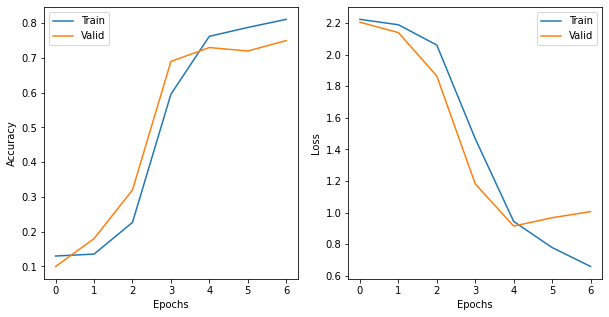

In [15]:
#  ## menampilkan history metrics akurasi dan loss 
import matplotlib.pyplot as plt

train_acc_list, train_loss_list, valid_acc_list, valid_loss_list, epochs_list = load_metrics(metrics_path)
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))

ax1.plot(epochs_list, train_acc_list, label='Train')
ax1.plot(epochs_list, valid_acc_list, label='Valid')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend()

ax2.plot(epochs_list, train_loss_list, label='Train')
ax2.plot(epochs_list, valid_loss_list, label='Valid')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()
plt.show() 

In [16]:
set_seed(42)

#Load model
mytokenizer = BertTokenizer.from_pretrained('indolem/indobert-base-uncased')

myconfig = BertConfig.from_pretrained('indolem/indobert-base-uncased',
                                    attention_probs_dropout_prob=0.3,
                                    hidden_dropout_prob=0.3)
myconfig.num_labels = LocationPredictionDataset.NUM_LABELS

# Instantiate model
mymodel = BertForSequenceClassification.from_pretrained('indolem/indobert-base-uncased', 
                                                      config=myconfig)


Some weights of the model checkpoint at indolem/indobert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indolem/indober

In [17]:
# menggunakan gpu  
best_model = mymodel.to(device)

optimizer = optim.AdamW(best_model.parameters(), lr=learning_rate)

load_checkpoint(model_path, best_model, optimizer)

best_model.eval()
torch.set_grad_enabled(False)

total_loss, total_correct, total_labels = 0, 0, 0
list_hyp, list_label = [], []

pbar = tqdm(test_loader, leave=True, total=len(test_loader))
for i, batch_data in enumerate(pbar):
    _, batch_hyp, _ = forward_sequence_classification(best_model, batch_data[:-1], i2w=i2w, device=device_idx)
    list_hyp += batch_hyp

# Save prediction
df = pd.DataFrame({'label':list_hyp}).reset_index()

100%|██████████| 16/16 [00:03<00:00,  4.05it/s]


In [18]:
## get y_test for user level
y_test_user_lvl = userlvltest.Lvalue
y_test_user_lvl.values

array([8, 6, 3, 0, 4, 1, 7, 4, 5, 1, 1, 7, 3, 5, 7, 0, 2, 4, 4, 2, 6, 2,
       7, 4, 2, 2, 1, 3, 2, 3, 1, 4, 1, 8, 2, 0, 1, 8, 6, 1, 8, 2, 2, 1,
       7, 4, 2, 3, 6, 0, 3, 4, 4, 3, 1, 5, 4, 0, 0, 2, 0, 4, 0, 3, 3, 3,
       7, 5, 7, 3, 3, 7, 3, 3, 3, 8, 3, 1, 6, 6, 5, 8, 5, 0, 1, 3, 7, 0,
       4, 8, 6, 0, 4, 2, 1, 5, 2, 5, 7, 8, 8, 6, 2, 4, 5, 4, 0, 7, 1, 2,
       0, 1, 8, 3, 8, 2, 0, 8, 4, 0, 4, 8, 2, 7, 3, 7, 2, 5, 6, 3, 3, 3,
       0, 4, 4, 0, 4, 8, 3, 2, 1, 1, 7, 6, 5, 5, 3, 1, 3, 6, 7, 8, 6, 5,
       2, 0, 2, 6, 1, 6, 8, 0, 7, 7, 1, 0, 4, 8, 8, 0, 6, 2, 4, 6, 4, 2,
       4, 8, 3, 1, 3, 6, 1, 6, 3, 8, 8, 1, 6, 0, 5, 8, 8, 3, 1, 2, 8, 2,
       0, 1, 2, 0, 4, 6, 2, 2, 6, 4, 0, 5, 6, 5, 4, 8, 5, 4, 7, 4, 3, 5,
       3, 8, 5, 2, 6, 8, 8, 5, 4, 4, 3, 7, 5, 2, 3, 0, 8, 1, 2, 1, 3, 4,
       1, 7, 4, 2, 5, 4, 3, 3])

In [19]:
## get y_pred for tweets level
y_pred_tweets_lvl = df.iloc[:,1].astype('category')
y_pred_tweets_lvl = y_pred_tweets_lvl.cat.codes
y_pred_tweets_lvl.values

array([1, 6, 1, 1, 3, 8, 7, 4, 5, 2, 1, 7, 3, 5, 7, 0, 2, 2, 3, 2, 6, 2,
       7, 4, 2, 2, 2, 3, 2, 3, 1, 3, 1, 8, 2, 0, 1, 8, 6, 1, 8, 2, 2, 6,
       7, 3, 2, 3, 6, 0, 3, 4, 4, 1, 1, 5, 4, 0, 1, 2, 0, 4, 0, 3, 3, 1,
       7, 5, 7, 4, 3, 7, 3, 3, 2, 3, 3, 4, 6, 6, 5, 8, 5, 1, 1, 3, 7, 0,
       4, 8, 6, 6, 3, 2, 1, 5, 2, 2, 7, 1, 8, 6, 2, 4, 1, 4, 3, 7, 1, 2,
       0, 1, 3, 3, 8, 2, 0, 8, 4, 0, 4, 8, 2, 7, 3, 1, 2, 5, 6, 3, 3, 3,
       2, 4, 4, 0, 4, 8, 4, 2, 1, 1, 7, 8, 5, 5, 3, 1, 6, 6, 2, 1, 6, 5,
       2, 6, 0, 6, 1, 6, 8, 0, 7, 4, 1, 0, 4, 8, 1, 3, 6, 4, 0, 6, 1, 1,
       3, 8, 3, 2, 3, 6, 1, 6, 3, 8, 1, 7, 6, 2, 5, 3, 8, 1, 1, 8, 8, 2,
       0, 1, 2, 0, 4, 6, 2, 2, 6, 4, 0, 2, 6, 5, 0, 8, 4, 4, 7, 3, 1, 3,
       2, 8, 5, 2, 6, 3, 0, 8, 4, 4, 2, 1, 7, 2, 3, 0, 8, 1, 1, 1, 3, 4,
       1, 7, 3, 8, 5, 4, 3, 4], dtype=int8)

In [20]:
from sklearn.metrics import classification_report, accuracy_score

## print classification report for user level prediction
print('accuracy %s' % round(accuracy_score(y_test_user_lvl, y_pred_tweets_lvl),2 ))
print(classification_report(y_test_user_lvl, y_pred_tweets_lvl,target_names=label_dict.keys()))

accuracy 0.73
                            precision    recall  f1-score   support

    bali dan nusa tenggara       0.81      0.65      0.72        26
               jabodetabek       0.53      0.75      0.62        28
     jawa barat dan banten       0.68      0.81      0.74        32
jawa tengah dan yogyakarta       0.62      0.67      0.64        36
                jawa timur       0.76      0.65      0.70        34
                kalimantan       1.00      0.68      0.81        22
          maluku dan papua       0.85      0.96      0.90        23
                  sulawesi       0.89      0.80      0.84        20
                  sumatera       0.79      0.66      0.72        29

                  accuracy                           0.73       250
                 macro avg       0.77      0.74      0.74       250
              weighted avg       0.75      0.73      0.73       250



In [21]:
y_pred_tweets_lvl.to_csv('bert_result/indoLEM_model_2e_5_batch16.csv')